In [1]:
import numpy as np
from __future__ import division

In [2]:
%matplotlib inline
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl

filename = "CML_Recording_Both.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [ ]:
# calculates and returns spectrogram of 
def get_wav(filename)
    filename = "CML_Recording_Both.wav"
    w = wave.open(filename,"rb")
    return w

# spectrogram is the absolute value of the stft
def get_sepctrogram(stft):
    return abs(stft)

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(w, win_size, overlap):
    # number of samples in the wave file
    n = len(w)
    win_count= 0
    

def my_istft(stft):
    

In [3]:
spectrum.shape

(129, 11263)

In [84]:
import numpy as np

# divergence
def div(v,W,h):
    whv = np.dot(W,h) * 1/v
    div = whv - np.log(whv) - 1
    div = np.dot( div, np.ones(div.shape) )
    return div

# divergence gradient
def div_grad(v,W,h):
    grad = np.dot( 1/v - 1/(np.dot(W,h)) , W)
    return grad

# epsilon divergence
def compute_obj(v,W,h,eps):
    
    whv = (np.dot(W,h) + eps)/(v + eps)
    if any(whv < 0):
        print(W)
        print(h)
        print(v)
        print('whv: ' + str(whv))
    #print('whv.shape: ' + str(whv.shape))
    #print('np.dot(W,h): ' + str(np.dot(W,h)))
    div = whv - np.log(whv) - 1
    #print(div)
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    #print('compute_grad start')
    #print('W.shape: ' + str(W.shape))
    #print('h.shape: ' + str(h.shape))
    #print('v.shape: ' + str(v.shape))
    #print('np.dot(W,h).shape: ' + str( (np.dot(W,h) + eps).shape ) )
    #print((1/(v + eps) - 1/(np.dot(W,h) + eps)).shape)
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    #print('compute_grad end')
    return grad

def itakura_saito(y,x):
    y = np.array(y)
    x = np.array(x)
    return np.sum(y/x - np.log(y/x) -1)
    
# important! input here has to be the matrix H, not the vector h_t
# this is because we need h_t but also h_(t-1) and h_(t+1)
# ind_t is the index of h_t in H
# lambda is the smoothness constant
def compute_smooth_obj(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # compute regular objective
    # maybe doing this direct instead of the function call is faster:
    # whv = (np.dot(W,h) + eps)/(v + eps)
    # div = whv - np.log(whv) - 1 
    div = compute_obj(v,W,h,eps)
    
    # compute smoothness terms
    s1 = H[:,ind_t]/H[:,ind_t-1]
    s2 = H[:,ind_t]/H[:,ind_t+1]
    sm = s1 - np.log(s1) - 1
    sm += s2 - np.log(s2) - 1
    # returning properly scaled smooth objective
    return div + lamb * np.sum( sm )
    
# input parameters as above
def compute_smooth_grad(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # calculates gradient of regular divergence
    div_grad = compute_grad(v,W,h,eps)

    # calculating gradient of smoothness term
    sm_grad = 1/H[:,ind_t-1] + 1/H[:,ind_t+1] - 2/H[:,ind_t]
    sm_grad = sm_grad.reshape(sm_grad.shape[0],1)
    
    # returning properly scaled gradient of smooth objective 
    return div_grad + lamb * sm_grad
    

In [85]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[-0.91200162]
 [ 0.42126031]]
[[-0.91199808]
 [ 0.42126121]]


In [86]:
def grad_checker(v,W,H,ind_t,lamb,eps):
    eps_dif = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(H[:,ind_t].shape)
    for i in range(k):
        ei = np.zeros(H.shape)
        ei[i,ind_t] = eps_dif
        t_grad[i] = (compute_smooth_obj(v,W,H+ei,ind_t,lamb,eps) - compute_smooth_obj(v,W,H-ei,ind_t,lamb,eps)) / (2*eps_dif)
    print(t_grad)
    print(compute_smooth_grad(v,W,H,ind_t,lamb,eps))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 3),1,1,1e-12)

[ 7.53544566  9.5102638 ]
[[ 7.53544693]
 [ 9.51026604]]


In [98]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
  
    beta = 0.5 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-4 # optimization precision
    n = 1e-1 #initial step size
    
    h = np.random.rand(2, 1)
    
    obj = [None]*max_iter
    
    max_backstep = 100 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        n = 1/beta*n # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - n * grad < 0)  and t < max_backstep ):
            t += 1
            n = beta * n
    
        new_obj = compute_obj(v,W,(h - n*grad),eps)
        while( new_obj > opt_prec * compute_obj(v,W,h,eps) and t < max_backstep):
            t += 1
            n = beta * n
            new_obj = abs(compute_obj(v,W,(h - n*grad),eps))
                      
        h = h - n * grad # update h according to gradient step
        k += 1 # update gradient step counter
       
   
    return h, obj[0:k]

h, obj = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)

[25.294090530377957, 9.523756099388935, 7.9600867384393883, 7.6123309624643438, 7.5394195057403977, 7.5046593723963975, 7.4961605757929686]


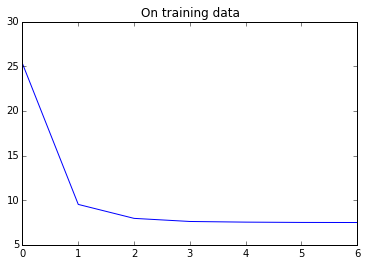

In [99]:
import matplotlib.pyplot as plt

index = [i for i in range(10)]
plt.title("On training data")
plt.plot([i for i in range(len(obj))], obj)

print(obj)

In [123]:
import random
def online_nmf(spectrum, W, H,A, B, rho, beta, n, eps):
   
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)

    t = 1
    W_old = W
    k = W.shape[1]
    h = np.random.rand(W.shape[1], 1)
    h_old = h
    
    while np.linalg.norm(W - W_old, ord = "fro") < n:
        
        t = t+1 
        
        ind = random.randint(0, len(spectrum.T)-1)
        print(ind)
        v = spectrum.T[ind]
        h_old = h
        h, obj = gradient_backtracking(v, W, h_old, 100, compute_grad, compute_obj, 1e-12)
   
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(np.dot(((eps+v)/(den**2)), h.T), np.dot(W.T,W))
        b += np.dot(1/den, h.T)
        
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            W = np.array([x/sum(x) for x in zip(*W)]).T
            A = np.array([x/sum(x) for x in zip(*A)]).T
            B = np.array([x*sum(x) for x in zip(*B)]).T
            
        if t > 95:
            print(W.shape)
            break

eps = 1e-12
v = spectrum.T[0]
K = 2
W = np.random.rand(spectrum.shape[0],K)
H = np.zeros((K, spectrum.shape[1]))

A = np.zeros(W.shape)
B = np.zeros(W.shape)

online_nmf(spectrum, W, H, A, B, 0.5, 100, 1e-3, eps)

10397
1159
7673
1195
8925
8117
8352
9888
2726
1144
3475
3826
3032
1861
2194
5991
10329
9339
1516
9884
390
7362
9378
7485
6431
9810
8308
8573
5932
9897
3574
3142
7137
10108
6775
3772
6585
5474
6239
5812
1689
5567
2060
7920
5159
9849
6252
3475
8488
3944
10605
7137
5211
3008
9898
3394
6706
1929
1727
5845
1167
5818
5789
5076
8082
7449
9597
7358
9852
8601
6206
15
1331
3413
3760
2098
1738
3532
7715
2317
10439
2162
7252
7377
5980
695
9375
11003
6948
7636
4654
3109
1814
10295
3446
(129, 2)


In [ ]:
eps = 1e-12
random.seed(12222015)

In [92]:
s = [sum(x) for x in zip(*W)]
W = [sum(x) for x in zip(*W)]

In [93]:
p.shape

(1, 129)

In [245]:
W = np.array([[1,1], [1,2], [2,2]])
X = [1,2]



In [246]:
W

array([[1, 1],
       [1, 2],
       [2, 2]])

In [237]:
X = W.T
for i in range(2):
    
    col_sum = X[i].sum()
    print(X[i]/col_sum)
    X[i] = (X[i]/col_sum)
    print(X[i])


[ 0.25  0.25  0.5 ]
[0 0 0]
[ 0.2  0.4  0.4]
[0 0 0]


In [251]:
z = np.array([x/sum(x) for x in zip(*W)])

In [252]:
z.T

array([[ 0.25,  0.2 ],
       [ 0.25,  0.4 ],
       [ 0.5 ,  0.4 ]])

In [ ]:
import numpy as np

# divergence
def div(v,W,h):
    whv = np.dot(W,h) * 1/v
    div = whv - np.log10(whv) - 1
    div = np.dot( div, np.ones )
    return div

# divergence gradient
def div_grad(v,W,h):
    grad = np.dot( 1/v - 1/(np.dot(W,h)) , W)
    return grad

# epsilon divergence
def eps_div(v,W,h,eps):
    whv = (np.dot(W,h) + eps) * 1/(v + eps)
    div = whv - np.log10(whv) - 1
    div = np.dot( div, np.ones )
    return div

# epsilon divergence gradient
def eps_div_grad(v,W,h,eps):
    grad = np.dot( 1/(v + eps) - 1/(np.dot(W,h) + eps), W)
    return grad